# Data Visualization

## Libraries

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
import json

## Constants

In [20]:
PATH = "../../"
IMAGES_PATH = PATH + "Dataset/images/"

csv_file = PATH + "Data/CSVs/dataset_caltech_yolo.csv"

predictions_file = PATH + "predictions.json"

In [2]:
category_mapping = {
    0: "bird",
    1: "cow",
    2: "domestic dog",
    3: "egyptian mongoose",
    4: "european badger",
    5: "european rabbit",
    6: "fallow deer",
    7: "genet",
    8: "horse",
    9: "human",
    10: "iberian hare",
    11: "iberian lynx",
    12: "red deer",
    13: "red fox",
    14: "wild boar",
}

family_mapping = {
    "bird": "",
    "cow": "",
    "domestic dog": "canidae",
    "egyptian mongoose": "",
    "european badger": "",
    "european rabbit": "leporid",
    "fallow deer": "cervid",
    "genet": "",
    "horse": "",
    "human": "",
    "iberian hare": "leporid",
    "iberian lynx": "",
    "red deer": "cervid",
    "red fox": "canidae",
    "wild boar": "",
}


In [22]:
# Load the files
df = pd.read_csv(csv_file)

with open(predictions_file, "r") as f:
    predictions_data = json.load(f)

## Functions

In [23]:
# Function to plot image with YOLO bounding box from original data
def plot_image_with_yolo_bbox(row):
    image_path = PATH + "Dataset/images/" + row['path']
    img = Image.open(image_path)
    img_width, img_height = img.size

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(row['path'])

    bboxes = eval(row['bounding_boxes']) if isinstance(row['bounding_boxes'], str) else []
    for bbox in bboxes:
        class_label = bbox[0]
        x_center, y_center, width, height = [float(coord) for coord in bbox[1:]]
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        width = width * img_width
        height = height * img_height
        
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.text(x_min, y_min, row['class'], color='r', backgroundcolor='black', fontsize=8)

    ax.axis('off')
    plt.show()

In [24]:
# Convert bbox from [x-center, y-center, width, height] to [x1, y1, width, height]
def convert_box(bbox, img_width, img_height):
    x_center, y_center, width, height = bbox
    x_min = (x_center - width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    width = width * img_width
    height = height * img_height

    return x_min, y_min, width, height

In [25]:
def unique_imagesids_from_predictions(list):
    unique_image_ids = []
    [unique_image_ids.append(prediction["image_id"]) for prediction in predictions_data if prediction["image_id"] not in unique_image_ids]

    return unique_image_ids

In [26]:
def filter_predictions(predictions_data, mode, n = 10, category_id = None):
    # Ensure mode is valid
    if mode not in ["best", "worst"]:
        raise ValueError("Invalid mode. Use 'best' or 'worst'.")

    # Sort the predictions_data based on the score
    sorted_predictions = sorted(predictions_data, key=lambda x: x["score"], reverse=(mode == "best"))
    
    unique_sorted_predictions = []
    if category_id is not None:
        [unique_sorted_predictions.append(prediction["image_id"]) for prediction in sorted_predictions if prediction["image_id"] not in unique_sorted_predictions and prediction["category_id"] == category_id]
    else:
        [unique_sorted_predictions.append(prediction["image_id"]) for prediction in sorted_predictions if prediction["image_id"] not in unique_sorted_predictions]

    # Extract the top n image IDs
    top_n_image_ids = unique_sorted_predictions[:n]

    return top_n_image_ids

In [27]:
def plot_n_images_from_imageids_list(image_id_list, n=None):
    if not n: n = len(image_id_list)
    # Iterate through predictions
    for image_id in image_id_list[:n]:  # Change the number of predictions you want to process

        # Find corresponding row in CSV
        csv_row = df[df["path"].str.contains(image_id, regex=False)]

        gt_bboxes = eval(csv_row["bounding_boxes"].values[0])

        filtered_predictions = [prediction for prediction in predictions_data if prediction["image_id"] == image_id]

        # Initialize lists to store the extracted fields
        category_ids = []
        scores = []
        bboxes = []

        # Loop through filtered predictions to extract fields
        for prediction in filtered_predictions:
            category_id = prediction["category_id"]
            score = prediction["score"]
            bbox = prediction["bbox"]

            category_ids.append(category_id)
            scores.append(score)
            bboxes.append(bbox)

        if not csv_row.empty:
            image_path = IMAGES_PATH + csv_row["path"].values[0]

            # Load image
            img = Image.open(image_path)
            img_width, img_height = img.size

            fig, ax = plt.subplots()
            ax.imshow(img)


            old_cat = ""
            count = 0

            # Ground Truth boxes
            for bbox in gt_bboxes:

                category_id = bbox[0]
                category_name = category_mapping.get(category_id, "Unknown")

                bbox = convert_box(bbox[1:], img_width, img_height)

                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), 
                    bbox[2], 
                    bbox[3], 
                    linewidth=5, 
                    edgecolor='g',
                    alpha=0.5, 
                    label=f"GT: {category_name}",
                    facecolor='none')
                
                ax.add_patch(rect)

                # Show class on plot
                plt.text(
                    bbox[0],#-220, 
                    bbox[1]-50,
                    f"{category_name}",
                    color="g",
                    #backgroundcolor="white",
                    alpha=0.8,
                )

            # Predicted boxes
            for idx, bbox in enumerate(bboxes):

                category_id = category_ids[idx]
                category_name = category_mapping.get(category_id, "Unknown")
                score = scores[idx]

                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), 
                    bbox[2], 
                    bbox[3],
                    linewidth=3, 
                    edgecolor='r', 
                    alpha=0.8,
                    facecolor='none',
                    label=f"{category_name} ({score:.2f})"
                )
                
                ax.add_patch(rect)

                # Show class and score on plot
                plt.text(
                    bbox[0], 
                    bbox[1],
                    f"{category_name} ({score:.2f})",
                    alpha=0.8,
                    color="r",
                    #backgroundcolor="white",
                )

            # Set title - category name = predicted category name todo
            title = f"Path: {csv_row['path'].values[0]}" #\nClass: {category_name}"
            ax.set_title(title)

            ax.legend()

            # Show plot
            plt.axis("off")
            plt.show()

### Plot n images

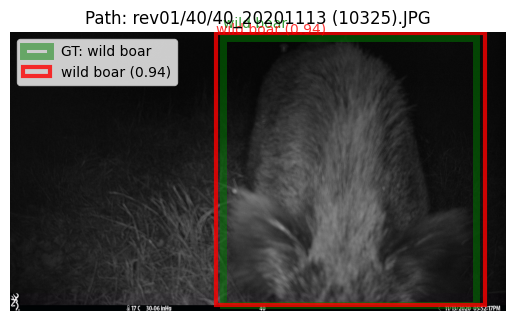

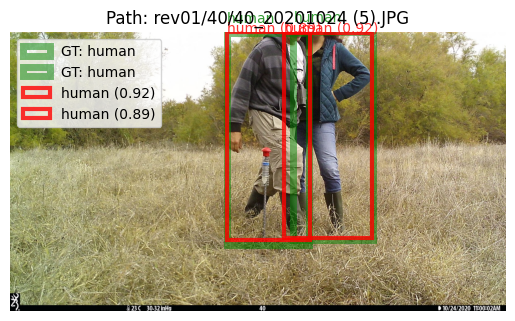

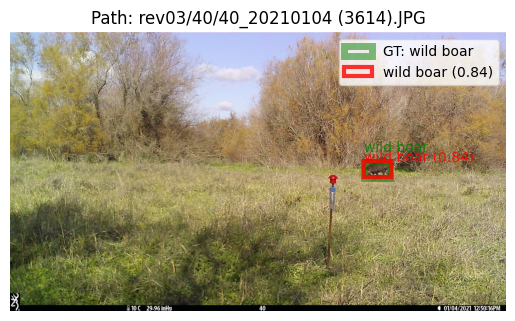

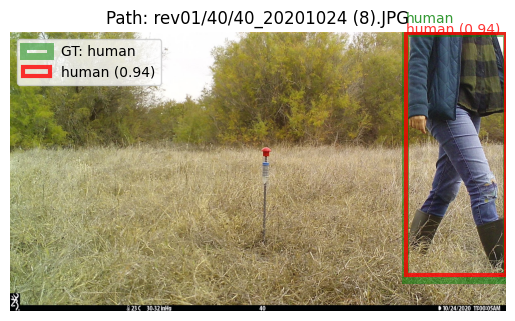

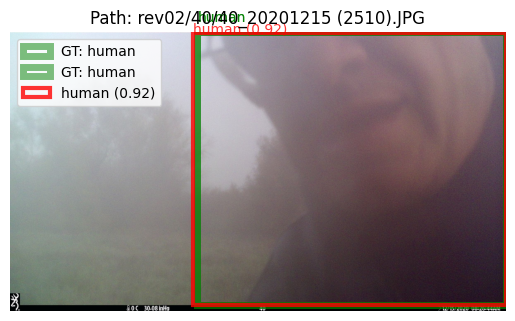

In [36]:
unique_image_ids = unique_imagesids_from_predictions(predictions_data)
random_unique_image_ids = unique_image_ids
random.shuffle(random_unique_image_ids)
plot_n_images_from_imageids_list(random_unique_image_ids, 5)

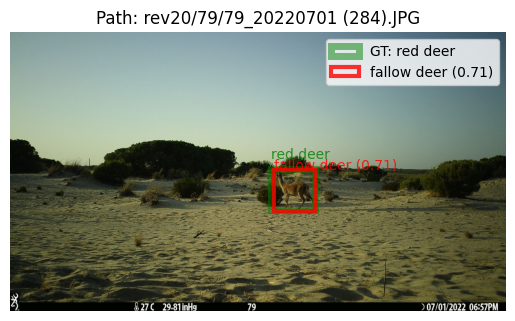

In [39]:
plot_n_images_from_imageids_list(["79_20220701 (284).JPG"], 1)

In [ ]:
top_n_image_ids = filter_predictions(predictions_data, mode="best", n=10)
plot_n_images_from_imageids_list(top_n_image_ids)

### Plot 1 random image with Ground Truth Bounding Boxes

In [30]:
# # Select a random row
# random_row = df.sample(n=1, random_state=random.randint(0, 1000)).iloc[0]

# # Plot the random image with YOLO bounding box
# plot_image_with_yolo_bbox(random_row)